In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [3]:
!pip install -q git+https://github.com/tensorflow/docs

In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

Downloading the data

In [5]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 4us/step


'/root/.keras/datasets/auto-mpg.data'

Data preparation

In [6]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

In [7]:
df = pd.read_csv(dataset_path, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)

In [8]:
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [9]:
df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [10]:
df.dropna(inplace=True)

In [11]:
df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


In [12]:
df['Origin'] = df['Origin'].map({1:'USA', 2:'Europe', 3: 'Japan'})

In [13]:
df = pd.get_dummies(df, prefix='', prefix_sep='')
df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1


In [14]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

Data visualisation

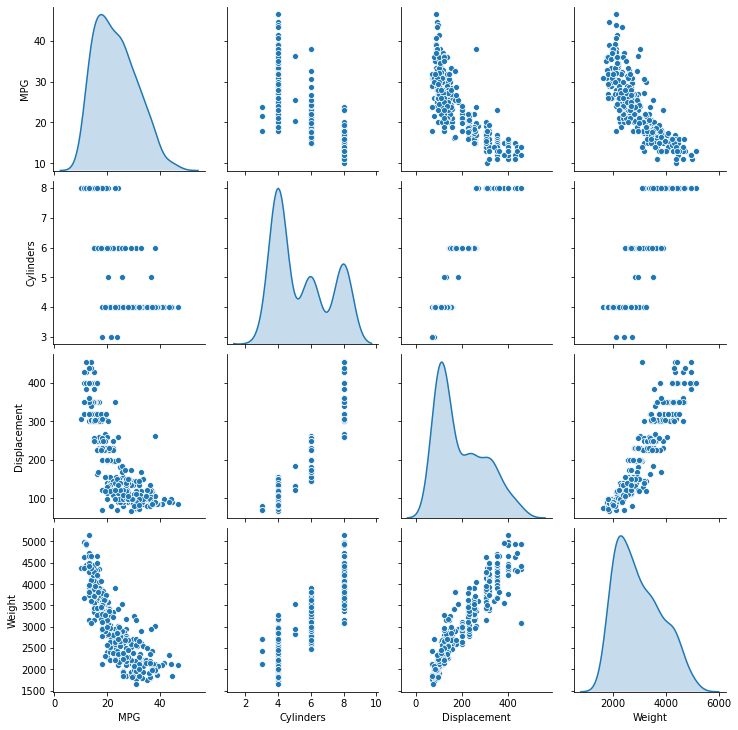

In [15]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [16]:
train_stats = train_dataset.describe()

In [17]:
train_stats.pop('MPG')

count    314.000000
mean      23.310510
std        7.728652
min       10.000000
25%       17.000000
50%       22.000000
75%       28.950000
max       46.600000
Name: MPG, dtype: float64

In [18]:
train_stats = train_stats.transpose()

In [19]:
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


Splitting features from labels

In [20]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

Data normalization

In [21]:
def norm(input):
  return (input - train_stats['mean'] / train_stats['std'])

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [22]:
def model_build():
  model = keras.Sequential([layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
                            layers.Dense(64, activation='relu'),
                            layers.Dense(1)])
  
  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(optimizer = optimizer,
                loss = 'mse',
                metrics = ['mae', 'mse'])

  return model

In [23]:
model = model_build()

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Tests of current model to check if outputs fits requirements

In [25]:
example_batch = normed_train_data[:10]
example_results = model.predict(example_batch)
example_results

array([[ -57.340057],
       [ -74.272415],
       [-109.98015 ],
       [ -55.29982 ],
       [ -56.970474],
       [ -77.56455 ],
       [ -52.592476],
       [ -78.4156  ],
       [ -77.099625],
       [ -63.187904]], dtype=float32)

Train model

In [48]:
EPOCHS = 1000

history = model.fit(normed_train_data,
                    train_labels,
                    epochs = EPOCHS,
                    validation_split=0.2,
                    verbose=0,
                    callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:65106.9688,  mae:173.0842,  mse:65106.9688,  val_loss:106.7441,  val_mae:8.8869,  val_mse:106.7441,  
....................................................................................................
Epoch: 100, loss:426.8322,  mae:18.5987,  mse:426.8322,  val_loss:182.1568,  val_mae:12.7603,  val_mse:182.1568,  
....................................................................................................
Epoch: 200, loss:87.1954,  mae:8.0379,  mse:87.1954,  val_loss:171.3557,  val_mae:11.0848,  val_mse:171.3557,  
....................................................................................................
Epoch: 300, loss:68.6135,  mae:7.4048,  mse:68.6135,  val_loss:42.8092,  val_mae:5.4584,  val_mse:42.8092,  
....................................................................................................
Epoch: 400, loss:43.9920,  mae:5.4221,  mse:43.9920,  val_loss:33.3612,  val_mae:5.1457,  val_mse:33.3612,  
.................................

Visualization of training process

In [49]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

In [50]:
hist

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,65106.968750,173.084183,65106.968750,106.744110,8.886930,106.744110,0
1,78.289139,6.986756,78.289139,73.451927,6.746991,73.451927,1
2,76.209724,6.984249,76.209724,65.083817,6.651273,65.083817,2
3,79.017883,6.979753,79.017883,77.531792,6.886888,77.531792,3
4,83.860886,7.439673,83.860886,62.290241,6.386073,62.290241,4
...,...,...,...,...,...,...,...
995,10.748453,2.497145,10.748453,31.753325,4.853771,31.753325,995
996,13.140705,2.791187,13.140705,9.219730,2.297841,9.219730,996
997,7.906588,2.081132,7.906588,12.224627,2.793211,12.224627,997
998,18.523262,3.394513,18.523262,10.179822,2.451709,10.179822,998


In [51]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

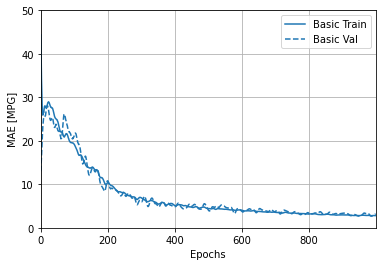

In [52]:
plotter.plot({'Basic': history}, metric='mae')
plt.ylim([0,50])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

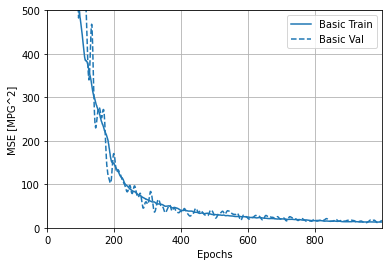

In [53]:
plotter.plot({'Basic': history}, metric='mse')
plt.ylim([0,500])
plt.ylabel('MSE [MPG^2]')

In [54]:
model = model_build()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:125817.0391,  mae:255.7090,  mse:125817.0391,  val_loss:940.9250,  val_mae:29.6781,  val_mse:940.9250,  
.............

In [57]:
early_history.history

{'loss': [125817.0390625,
  349.4175720214844,
  205.05030822753906,
  199.5067901611328,
  205.67108154296875,
  1660.4744873046875,
  1714.1253662109375,
  1778.702392578125,
  2037.42919921875,
  1054.5369873046875,
  2155.266357421875,
  2079.173095703125,
  1089.302734375],
 'mae': [255.70904541015625,
  15.921321868896484,
  12.648070335388184,
  12.541288375854492,
  12.193010330200195,
  30.720142364501953,
  36.384986877441406,
  38.21446228027344,
  37.23781967163086,
  25.03316879272461,
  40.951820373535156,
  41.186431884765625,
  27.111148834228516],
 'mse': [125817.0390625,
  349.4175720214844,
  205.05030822753906,
  199.5067901611328,
  205.67108154296875,
  1660.4744873046875,
  1714.1253662109375,
  1778.702392578125,
  2037.42919921875,
  1054.5369873046875,
  2155.266357421875,
  2079.173095703125,
  1089.302734375],
 'val_loss': [940.9249877929688,
  221.4291534423828,
  211.06825256347656,
  253.98245239257812,
  212.8682403564453,
  4147.318359375,
  1000.996582

ValueError: ignored

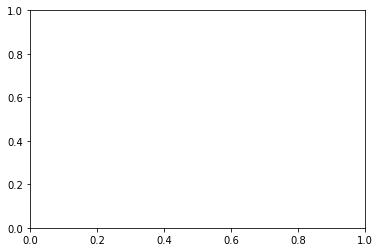

In [59]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')


In [60]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print(f'Testing set Mean Absolute Error: {mae:5.2f} MPG')

3/3 - 0s - loss: 4071.2532 - mae: 55.8443 - mse: 4071.2532
Testing set Mean Absolute Error: 55.84 MPG


Prediction

In [61]:
test_prediction = model.predict(normed_test_data).flatten()

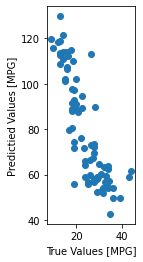

In [64]:
a = plt.axes(aspect = 'equal')
plt.scatter(test_labels, test_prediction)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predicted Values [MPG]')

_ = plt.plot()